# GridWorld Capture the Flag MVP Environment

In [1]:
from gridworld_ctf_mvp import GridworldCtf
from dqn_agent import DQNAgent
from dqn_network import DQNNetwork
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from IPython.display import clear_output
import random
from matplotlib import pyplot as plt
from collections import deque
import copy
import time

# Check that current MacOS version is at least 12.3+
print(torch.backends.mps.is_available())
# Check that the current current PyTorch installation was built with MPS activated.
print(torch.backends.mps.is_built())

False
False


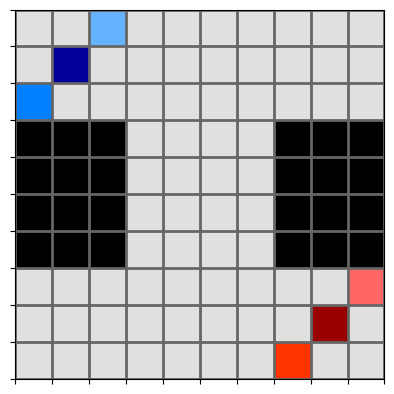

In [2]:
# instantiate environment
env = GridworldCtf(game_mode='random')
env.render()

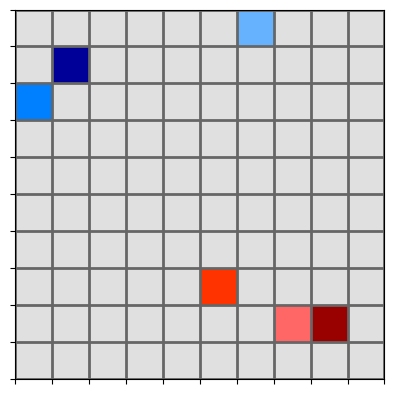

steps: 21
rewards: [-1, -1, -1, -1]
done: False
has flag: [0 0 0 0]


In [8]:
# basic example of mechanics
env = GridworldCtf(game_mode='static')

env.reset()
max_steps = 20
done = False
i = 0

while not done:
    actions = np.random.randint(4, size=4)
    _, rewards, done = env.step(actions)
    env.render()
    i += 1
    if i > max_steps:
        break
    
print(f"steps: {i}")
print(f"rewards: {rewards}")
print(f"done: {done}"), 
print(f"has flag: {env.has_flag}")

### DQN

### Multi-agent version

In [9]:
def add_noise(env_dims):
    """
    Add noise to stabilise training.
    """
    return np.random.rand(*env_dims)/100.0

def get_env_metadata(agent_idx, has_flag, device='cpu'):
    """
    Get agent turn and flag holder info.
    """
    agent_turn = np.array([0, 0, 0, 0], dtype=np.int8)
    agent_turn[agent_idx] = 1

    return torch.cat((torch.from_numpy(agent_turn), torch.from_numpy(has_flag))).reshape(1, 8).float().to(device)


In [6]:
# train agent
env = GridworldCtf(game_mode='static')
device = "cpu"

agent = DQNAgent(q_network=DQNNetwork(device=device),
                batch_size=128,
                gamma=0.9,
                lr=0.00025,
                epsilon=0.3,
                target_update_steps=1000,
                mem_size=10000,
                n_actions=4)

# train agents
env_dims = (1, 1, 10, 10)
epochs = 3000
losses = []
score_history = []
n_random_steps = 2000
max_steps = 500
h = 0
step_count = 0

for i in range(epochs):
    env.reset()

    curr_grid_state_ = env.grid.reshape(*env_dims) + add_noise(env_dims)
    curr_grid_state = torch.from_numpy(curr_grid_state_).float().to(device)

    done = False
    episode_steps = 0
    score = 0
    while not done: 
        step_count += 1
        episode_steps += 1

        # Collect actions for each agent
        actions =[]
        for agent_idx in env.dice_roll():
            curr_metadata_state = get_env_metadata(agent_idx, env.has_flag, device=device)
            actions.append(agent.choose_action(curr_grid_state, curr_metadata_state))

        # Step the environment
        new_grid_state, rewards, done = env.step(actions)
        new_grid_state_ = new_grid_state.reshape(*env_dims) + add_noise(env_dims)
        new_grid_state = torch.from_numpy(new_grid_state_).float().to(device)

        # Increment score
        score += sum(rewards)

        # Store each agent experiences
        for agent_idx in np.arange(4):
            new_metadata_state = get_env_metadata(agent_idx, env.has_flag, device=device)

            # Append replay buffer
            agent.memory.append(
                                ((curr_grid_state, curr_metadata_state), 
                                 actions[agent_idx], 
                                 rewards[agent_idx], 
                                 (new_grid_state, new_metadata_state), 
                                 done)
                                )
        curr_grid_state = new_grid_state
        
        # Learning
        if len(agent.memory) > agent.batch_size:
            loss = agent.update_network(step_count)
        else:
            loss = 0.0

        # Append metrics
        losses.append(loss)  

        if episode_steps > max_steps:
            break

    score_history.append(score)
    
    if i % 5 == 0:
        clear_output(wait=True)
        print(f'episode: {i} \nstep count: {step_count} \nscore: {score} \naverage score: {np.mean(score_history[-100:])}')

losses = np.array(losses)
agent.save_model()
#A Set the update frequency for synchronizing the target model parameters to the main DQN
#B Use the target network to get the maiximum Q-value for the next state
#C Copy the main model parameters to the target network

episode: 1070 
step count: 101783 
score: -127 
average score: -191.52


KeyboardInterrupt: 

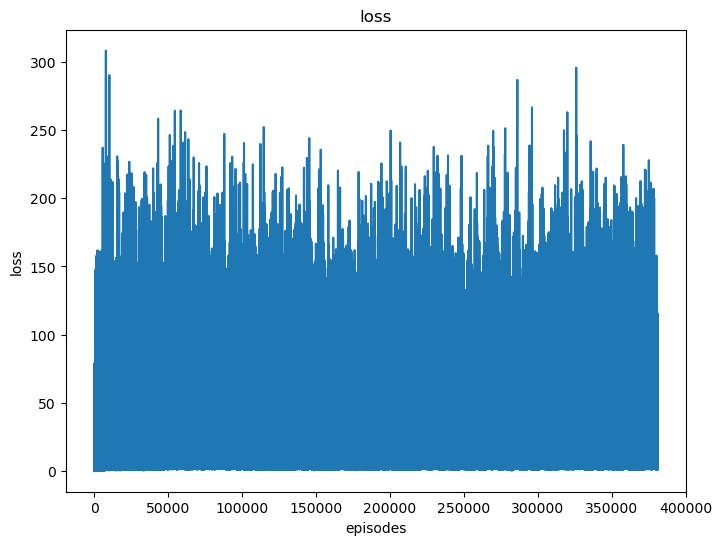

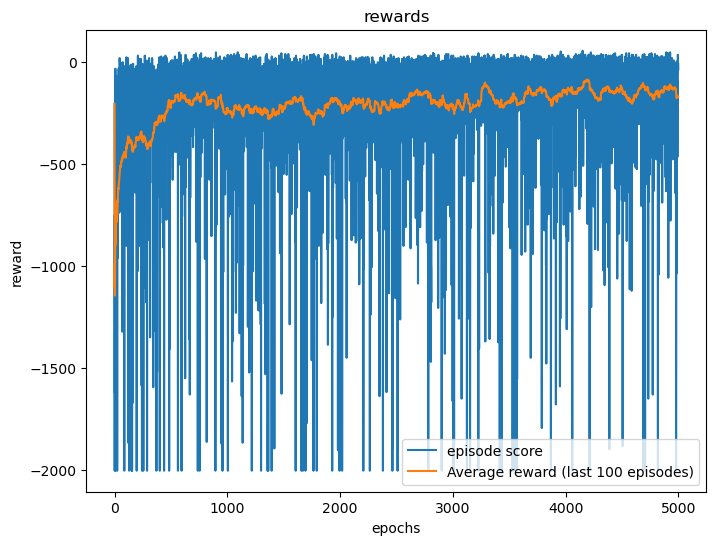

In [13]:
# Plot losses
plt.figure(figsize=(8, 6))
plt.title('loss')
plt.plot(losses)
plt.xlabel("episodes")
plt.ylabel("loss")

# Plot rewards
plt.figure(figsize=(8, 6))
plt.title('rewards')
plt.plot(score_history, label='episode score')
plt.plot([np.mean(score_history[::-1][i:i+100]) for i in range(len(score_history))][::-1], label='Average reward (last 100 episodes)')
plt.xlabel("epochs")
plt.ylabel("reward")
plt.legend()
plt.show()

Game lost; too many moves. Final score: -204


False

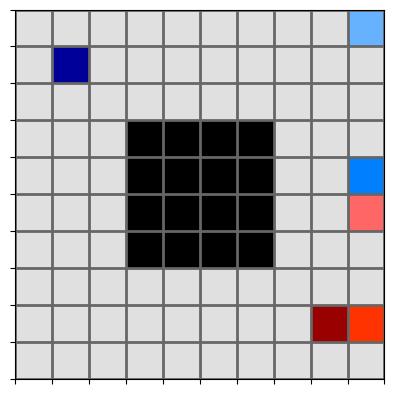

In [17]:
def test_model(env, agent, env_dims, display=True, max_moves=50):
    env.reset()

    curr_grid_state_ = env.grid.reshape(*env_dims) + add_noise(env_dims)
    curr_grid_state = torch.from_numpy(curr_grid_state_).float().to(device)

    done = False
    step_count = 0
    score = 0
    while not done: 
        step_count += 1

        # Collect actions for each agent
        actions =[]
        for agent_idx in env.dice_roll():
            curr_metadata_state = get_env_metadata(agent_idx, env.has_flag)
            actions.append(agent.choose_action(curr_grid_state, curr_metadata_state))

        # Step the environment
        new_grid_state, rewards, done = env.step(actions)
        new_grid_state_ = new_grid_state.reshape(*env_dims) + add_noise(env_dims)
        new_grid_state = torch.from_numpy(new_grid_state_).float().to(device)

        # Increment score
        score += sum(rewards)

        if display:
            env.render(sleep_time=0.25)

        if done:
            if display:
                print("Game won! score: %s" % (score,))
       
        if (step_count > max_moves):
            if display:
                print(f"Game lost; too many moves. Final score: {score}")
            break
    
    win = True if done else False
    return win

env_dims = (1, 1, 10, 10)
test_model(env, agent, env_dims, display=True)